# Teoría de Markovitz aplicada a Portfolio Managment

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [153]:
df_preciosPort=pd.read_excel(r"C:\Users\AN012491\Desktop\var clase 01abr20.xlsx","Precios",index_col=0)
rends=df_preciosPort.pct_change().fillna(0)

### Funciones de rendimiento esperado y volatilidad de un portafolio

In [154]:
'''
Rendimientos anualizados
'''
def mean_port(w,r):
    Ep=(r.mean()@w)*252
    return Ep

def ds_port(w,r):
    Sp=np.sqrt(w.T@(r.cov()*252)@w)
    return Sp

In [155]:
'''
Rendimientos diarios
'''
def mean_port_diario(w,r):
    Ep=(r.mean()@w)
    return Ep

def ds_port_diario(w,r):
    Sp=np.sqrt(w.T@(r.cov())@w)
    return Sp

### Simulación de pesos 

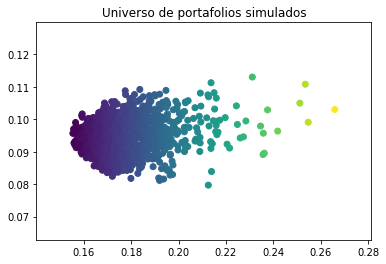

In [156]:
'''

_____________________________________ Universo de portafolios simulados ________________________________________________

'''
rend=rends
np.random.seed(12345)
f,c=rend.shape
n_sim=1000
w_sim=np.random.rand(n_sim,c)

for i in range(n_sim):
    w_sim[i]=w_sim[i]/sum(w_sim[i])

rend_sim=[mean_port(W,rend) for W in w_sim]
ds_sim=[ds_port(W,rend) for W in w_sim]
plt.scatter(ds_sim,rend_sim,c=ds_sim, cmap='viridis')
plt.title('Universo de portafolios simulados')
plt.show()

A continuación mostramos como calcular los portafolios de mínima varianza y que maximizan el radio de Sharpe dado un nivel de rendimiento esperado. Se usará éste método para construir la frontera eficiente de portafolios que maximicen el radio para un intervalo de rendimientos esperados.

In [157]:
w0=w_sim[ds_sim.index(min(ds_sim))]

#Paso 1. Portafolio de mínima varianza:
def sum_w(w):
    return w.sum()-1

constrains=[{"type":"eq","fun":sum_w}]
port=minimize(ds_port,x0=w0,constraints=constrains,args=rend)
w1=port.x

#Paso 2. Portafolio que maximiza el sharpe-ratio dado un rendimiento esperado fijo:
def rend_esp(w,E):
    return mean_port(w,rend)-E

e0=0.1
constrains2=[{"type":"eq","fun":sum_w},{"type":"eq","fun":lambda w:rend_esp(w,e0)}]
port1=minimize(ds_port,x0=w0,constraints=constrains2,args=rend)

print(f"Portafolio de mínima varianza sin restricciones adicionales: {w1}")
print(f"Portafolio que maxmiza el radio de Sharpe con rendimiento del 10%: {port1.x}")

Portafolio de mínima varianza sin restricciones adicionales: [0.28288914 0.04285646 0.09018132 0.30916734 0.27490574]
Portafolio que maxmiza el radio de Sharpe con rendimiento del 10%: [0.37475691 0.00577788 0.1076726  0.2787109  0.23308171]


### Construcción de fronteras eficientes

## Portafolio tangencial

Portafolio cuya pendiente toca transversalmente la linea: 
$$
    \mathbb{E}[R_C] = R_f + \frac{\mathbb{E}[R_p] - R_f}{\sigma_P}\sigma_C
$$

Dado un activo libre de riesgo con rendimiento $R_f$.

Esto es, buescamos el portafolio que maximiza el radio de Sharpe: 

$$
\frac{\mathbb{E}[R_p] - R_f}{\sigma_P}
$$

In [158]:
rf = 0.06
w0=w_sim[ds_sim.index(min(ds_sim))]

def sum_w(w):
    return w.sum()-1

constrains_sharpe=[{"type":"eq","fun":sum_w},{"type":"ineq","fun":lambda wx:1-wx},{"type":"ineq","fun":lambda wx:wx}]

def min_func_sharpe(w):
    return - (mean_port(w, rend) - rf) / ds_port(w, rend)

f_sharpe = minimize(min_func_sharpe, x0=w0, constraints=constrains_sharpe)

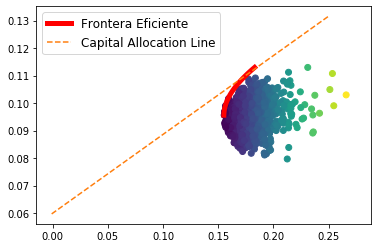

In [159]:
w_sharpe=f_sharpe.x
e_sharpe = mean_port(w_sharpe, rend)
vol_sharpe = ds_port(w_sharpe, rend)

rango_fronteraEf=np.linspace(rend_sim[ds_sim.index(min(ds_sim))],max(rend_sim),50)
pesos_fronteraEf=[]

for e in rango_fronteraEf:
    constrains2=[{"type":"eq","fun":sum_w},{"type":"eq","fun":lambda w:rend_esp(w,e)}]
    port1=minimize(ds_port,x0=w_sim[ds_sim.index(min(ds_sim))],constraints=constrains2,args=rend)
    pesos_fronteraEf.append(port1.x)

dominio_fronteraEf=[ds_port(p,rend) for p in pesos_fronteraEf]

sigma_c =  np.linspace(-1e-3, 0.25)
sharpe = rf + sigma_c * (e_sharpe - rf) / vol_sharpe

plt.scatter(ds_sim,rend_sim,c=ds_sim, cmap='viridis')
plt.plot(dominio_fronteraEf,rango_fronteraEf,color="red",linewidth=5,label="Frontera Eficiente")
plt.plot(sigma_c, sharpe, linestyle="--", c="tab:orange", label="Capital Allocation Line")
plt.legend(fontsize=12)
plt.show()

## Cálculo del VaR

In [160]:
def VaR_individual(S,w,F,rend):
    M=rend.cov()
    llaves=list(rend.keys())
    S_anual=0
    S_diaria=0
    VaR_ind_diario={k:w[i]*S*F*M.iloc[0].iloc[0]**0.5 for i,k in enumerate(llaves)}
    VaR_ind_anual={k:(252**0.5)*w[i]*S*F*M.iloc[0].iloc[0]**0.5 for i,k in enumerate(llaves)}
    for i in range(len(w)):
        S_anual+=(252**0.5)*w[i]*S*F*np.sqrt(M.iloc[0].iloc[0])
        S_diaria+=w[i]*S*F*np.sqrt(M.iloc[0].iloc[0])
    return VaR_ind_diario,VaR_ind_anual,S_anual,S_diaria

In [161]:
import ipywidgets as widgets
from scipy.stats import norm
from ipywidgets import interact,interact_manual
from IPython.display import display

F_95=norm.ppf(0.95,loc=0,scale=1)
F_99=norm.ppf(0.99,loc=0,scale=1)
l=list(rend.keys())

print("En caso de seleccionar los pesos, no se debe preocupar que sumen 1")

F_slider=widgets.Dropdown(
    options=[('95%',F_95),('99%',F_99)],
    value=F_95,
    description='Nivel de confianza:',
    disabled=False,
)

t_slider=widgets.Dropdown(
    options=['anual','diaria'],
    value='anual',
    description='Horizonte:',
    disabled=False,
)

S_slider=widgets.IntSlider(
    value=int(5e4),
    min=int(1e4),
    max=int(1e7),
    step=int(1e4),
    description='Monto (P$):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

b_slider=widgets.Dropdown(
    options=[('Si',0),('No',1)],
    value=1,
    description='Ingresar pesos:',
    disabled=False,
)

p1_slider=widgets.FloatSlider(
    value=0,
    min=0,
    max=1,
    step=1/50,
    description='peso para '+l[0]+': ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f'
)

p2_slider=widgets.FloatSlider(
    value=0,
    min=0,
    max=1,
    step=1/50,
    description='peso para '+l[1]+': ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f'
)

p3_slider=widgets.FloatSlider(
    value=0,
    min=0,
    max=1,
    step=1/50,
    description='peso para '+l[2]+': ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f'
)

p4_slider=widgets.FloatSlider(
    value=0,
    min=0,
    max=1,
    step=1/50,
    description='peso para '+l[3]+': ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f'
)

p5_slider=widgets.FloatSlider(
    value=0,
    min=0,
    max=1,
    step=1/50,
    description='peso para '+l[4]+': ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f'
)

def VaR_interactivo(F,S,t,b,p1,p2,p3,p4,p5):
    llaves = list(rend.keys())
    if b == 0:
        W=[p1,p2,p3,p4,p5]
        W=np.array(W)
        W=W/np.sum(W)
        v_anual=ds_port(W,rend)
        v_diaria=ds_port_diario(W,rend)
        w=W
    else:
        v_anual=vol_sharpe
        v_diaria=vol_sharpe*(1/252)**0.5
        w=w_sharpe
        
    VaR_ind_diario,VaR_ind_anual,S_anual,S_diaria=VaR_individual(S,w,F,rend)
    
    if t=="anual":
        
        print(f"El VaR anual asociado al nivel de confianza y el monto seleccionado es {round(F*S*v_anual,2)} P$")
        for i in list(VaR_ind_anual.keys()):
            print(f"El VaR anual individual de {i} es {round(VaR_ind_anual[i],2)}")
        print(f"La exposición por diversificación anual es: {round(S_anual-F*S*v_anual,2)}")
    else:
        print(f"El VaR diario asociado al nivel de confianza y el monto seleccionado es {round(F*S*v_diaria,2)} P$")
        for i in list(VaR_ind_diario.keys()):
            print(f"El VaR diario individual de {i} es {round(VaR_ind_diario[i],2)}")
        print(f"La exposición por diversificación diaria es: {round(S_diaria-F*S*v_diaria,2)}")
        
w=interact_manual(VaR_interactivo,F=F_slider,S=S_slider,t=t_slider,b=b_slider,p1=p1_slider,p2=p2_slider,p3=p3_slider,p4=p4_slider,p5=p5_slider)


En caso de seleccionar los pesos, no se debe preocupar que sumen 1


interactive(children=(Dropdown(description='Nivel de confianza:', options=(('95%', 1.6448536269514722), ('99%'…